<a href="https://colab.research.google.com/github/skashyapsri/Absorbance-Prediction-Using-ML/blob/main/Numerical_Deconvolution_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

EVOO_DENSITY = 0.91
COLORS = ['gray', 'cyan', 'blue', 'orange', 'red', 'yellow', 'pink', 'brown']

datasets = [
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/evoo_test.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/fresh_evoo.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/mais_seed_oil.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/monocultivar_frantoio.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/rapeseed_oil.csv'
]

pigments_data = pd.read_csv('https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/pigments/pigments.csv', delimiter=';', comment='#')
pigments_data = pigments_data.rename(columns={'Wavelength (nm)': 'Wavelength'})

def processSpectra(evoo_samples, pigments_data):
    X_EVOO = evoo_samples['Wavelength'].values
    ABS_EVOO = evoo_samples['Absorbance'].values

    X_REF = pigments_data['Wavelength'].values[2:]
    X_REF = X_REF.astype(float)
    EPS_REF = pigments_data.iloc[2:, 1:].astype(float).values

    min_wavelength = max(X_EVOO.min(), X_REF.min())
    max_wavelength = min(X_EVOO.max(), X_REF.max())

    evoo_mask = (X_EVOO >= min_wavelength) & (X_EVOO <= max_wavelength)
    ref_mask = (X_REF >= min_wavelength) & (X_REF <= max_wavelength)

    X_EVOO = X_EVOO[evoo_mask]
    ABS_EVOO = ABS_EVOO[evoo_mask]
    X_REF = X_REF[ref_mask]
    EPS_REF = EPS_REF[ref_mask]

    f = interpolate.interp1d(X_EVOO, ABS_EVOO, kind='cubic', fill_value='extrapolate')
    ABS_EVOO_interp = f(X_REF)

    return X_REF, EPS_REF, X_REF, ABS_EVOO_interp

def plot(X_EVOO, ABS_EVOO, FILTER, X_REF, EPS_REF, ABS_CALC=None, ABS_CALC_CONTR=None, title=''):
    fig = plt.figure(figsize=(12, 7), dpi=100)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.title(f'EVOO Deconvolution - {title}')
    plt.xlim(np.min(X_EVOO), np.max(X_EVOO))
    plt.ylim(0, np.max(ABS_EVOO)+np.max(ABS_EVOO)*0.05)

    EXP = ABS_EVOO

    plt.plot(X_EVOO, EXP, '.', markersize=3, color='gray', label='Experimental Data')
    if len(X_REF):
        plt.plot(X_REF, ABS_EVOO, '-k', linewidth=0.8, label='EVOO')

    if ABS_CALC is not None and len(ABS_CALC) > 0:
        plt.plot(X_REF, ABS_CALC, '-g', label='Calculated')
        PIGMENTS = pigments_data.columns[1:].tolist()
        for i in range(len(PIGMENTS)):
            plt.plot(X_REF, ABS_CALC_CONTR[:, i], linewidth=0.8, color=COLORS[i],
                     label=f'{PIGMENTS[i]}')

    plt.legend(loc='best', fontsize='small')
    plt.tight_layout()
    plt.show()

def deconvolve(X, EPS_REF, ABS_EVOO, MW):
    N_PIGMENTS = np.shape(EPS_REF)[1]
    ovlp = np.zeros((N_PIGMENTS, N_PIGMENTS))
    for i in range(N_PIGMENTS):
        for j in range(i, N_PIGMENTS):
            prod = np.multiply(EPS_REF[:, i], EPS_REF[:, j])
            ovlp[i, j] = np.trapz(prod, X[::-1])
    ovlp = ovlp+ovlp.T-np.eye(N_PIGMENTS)*np.diag(ovlp)

    eigval, eigvec = np.linalg.eigh(ovlp, UPLO='U')

    check = np.where(eigval == 0)[0]
    if (len(check) > 0):
        msg = f"\nError!\n{len(check)} eigenvalues are zero\nDeconvolution is not possible!\n"
        print(msg)
        return np.zeros(N_PIGMENTS)

    base = np.einsum('ri,jr->ji', eigvec, EPS_REF)

    gamma = np.zeros(N_PIGMENTS)
    for i in range(N_PIGMENTS):
        gamma[i] = -np.trapz(base[:, i]*ABS_EVOO/eigval[i], X)

    concmol = np.einsum('k,ik->i', gamma, eigvec)

    return concmol

def printResults(ABS_EVOO, ABS_CALC, PIGMENTS, concppm, txt):
    ave = np.average(ABS_EVOO)
    Rsq = 1 - np.sum((ABS_EVOO - ABS_CALC)**2) / np.sum((ABS_EVOO - ave)**2)

    print(f'Final results: {txt}')
    print(f'R-square = {Rsq:.6f}')
    print('    PIGMENT CONCENTRATION')
    print('-------------------------------')
    for pigment, conc in zip(PIGMENTS, concppm):
        if conc > 1e4:
            print(f'{pigment:12s} = ********* mg/kg')
        else:
            print(f'{pigment:12s} = {conc:9.3f} mg/kg')
    print('-------------------------------')
    total_conc = np.sum(concppm[concppm < 1e4])
    print(f'PIGMENT TOTAL = {total_conc:9.3f} mg/kg')

def analyze_dataset(file_url, pigments_data):
    print(f"\nAnalyzing dataset: {file_url.split('/')[-1]}")
    evoo_samples = pd.read_csv(file_url, delimiter=';')
    evoo_samples.columns = ['Wavelength', 'Absorbance']

    X_REF, EPS_REF, X_EVOO, ABS_EVOO = processSpectra(evoo_samples, pigments_data)

    PIGMENTS = pigments_data.columns[1:].tolist()
    MW = pigments_data.iloc[0, 1:].astype(float).values
    FILTER = np.ones(len(PIGMENTS), dtype=bool)

    try:
        concmol = deconvolve(X_REF, EPS_REF, ABS_EVOO, MW)
        concppm = concmol * MW * 1000 / EVOO_DENSITY

        ABS_CALC_CONTR = EPS_REF*concmol
        ABS_CALC = np.einsum('ik,k->i', EPS_REF, concmol)

        printResults(ABS_EVOO, ABS_CALC, PIGMENTS, concppm, 'AUTO FITTING')

        plot(X_EVOO, ABS_EVOO, FILTER, X_REF, EPS_REF, ABS_CALC, ABS_CALC_CONTR, title=file_url.split('/')[-1])

    except ValueError as e:
        print(f"An error occurred during deconvolution: {e}")
        plot(X_EVOO, ABS_EVOO, FILTER, X_REF, EPS_REF, title=file_url.split('/')[-1])

# # Analyze all datasets
# for dataset in datasets:
#     analyze_dataset(dataset, pigments_data)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.gridspec import GridSpec

def create_ieee_figure(datasets, pigments_data):
    # Ensure each dataset is unique
    unique_datasets = list(dict.fromkeys(datasets))

    name_mapping = {
        'evoo_test.csv': 'a) Standard EVOO',
        'fresh_evoo.csv': 'b) Fresh EVOO',
        'mais_seed_oil.csv': 'c) Maize Seed Oil',
        'monocultivar_frantoio.csv': 'd) Monocultivar Frantoio',
        'rapeseed_oil.csv': 'e) Rapeseed Oil'
    }

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Liberation Serif']
    plt.rcParams['text.usetex'] = False
    plt.rcParams['mathtext.fontset'] = 'stix'

    SMALL_SIZE = 6
    MEDIUM_SIZE = 8
    BIGGER_SIZE = 9

    plt.rc('font', size=MEDIUM_SIZE)
    plt.rc('axes', titlesize=MEDIUM_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)
    plt.rc('legend', fontsize=SMALL_SIZE)
    plt.rc('figure', titlesize=BIGGER_SIZE)

    fig = plt.figure(figsize=(8.27, 11.69), dpi=300)
    gs = GridSpec(3, 2, figure=fig)
    gs.update(wspace=0.3, hspace=0.4)

    COLORS = ['gray', 'cyan', 'blue', 'orange', 'red', 'yellow', 'pink', 'brown']
    EVOO_DENSITY = 0.91

    for idx, dataset in enumerate(unique_datasets):
        ax = fig.add_subplot(gs[idx // 2, idx % 2] if idx < 4 else gs[2, 0:])

        evoo_samples = pd.read_csv(dataset, delimiter=';')
        evoo_samples.columns = ['Wavelength', 'Absorbance']

        X_REF, EPS_REF, X_EVOO, ABS_EVOO = processSpectra(evoo_samples, pigments_data)
        PIGMENTS = pigments_data.columns[1:].tolist()
        MW = pigments_data.iloc[0, 1:].astype(float).values

        try:
            concmol = deconvolve(X_REF, EPS_REF, ABS_EVOO, MW)
            ABS_CALC_CONTR = EPS_REF * concmol
            ABS_CALC = np.einsum('ik,k->i', EPS_REF, concmol)

            ax.plot(X_EVOO, ABS_EVOO, '.', markersize=1, color='gray', label='Experimental')
            ax.plot(X_REF, ABS_CALC, '-', linewidth=0.5, color='green', label='Calculated')

            for i, pigment in enumerate(PIGMENTS):
                ax.plot(X_REF, ABS_CALC_CONTR[:, i], linewidth=0.5, color=COLORS[i],
                       label=pigment.replace('_', ' '))

        except ValueError:
            ax.plot(X_EVOO, ABS_EVOO, '.', markersize=1, color='gray', label='Experimental')

        filename = dataset.split('/')[-1]
        title = name_mapping.get(filename, filename)

        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Absorbance')
        ax.set_title(title)

        if idx == len(unique_datasets) - 1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                     borderaxespad=0., frameon=False)
        else:
            ax.legend(['Exp.', 'Calc.'], loc='best', frameon=False)

    return fig

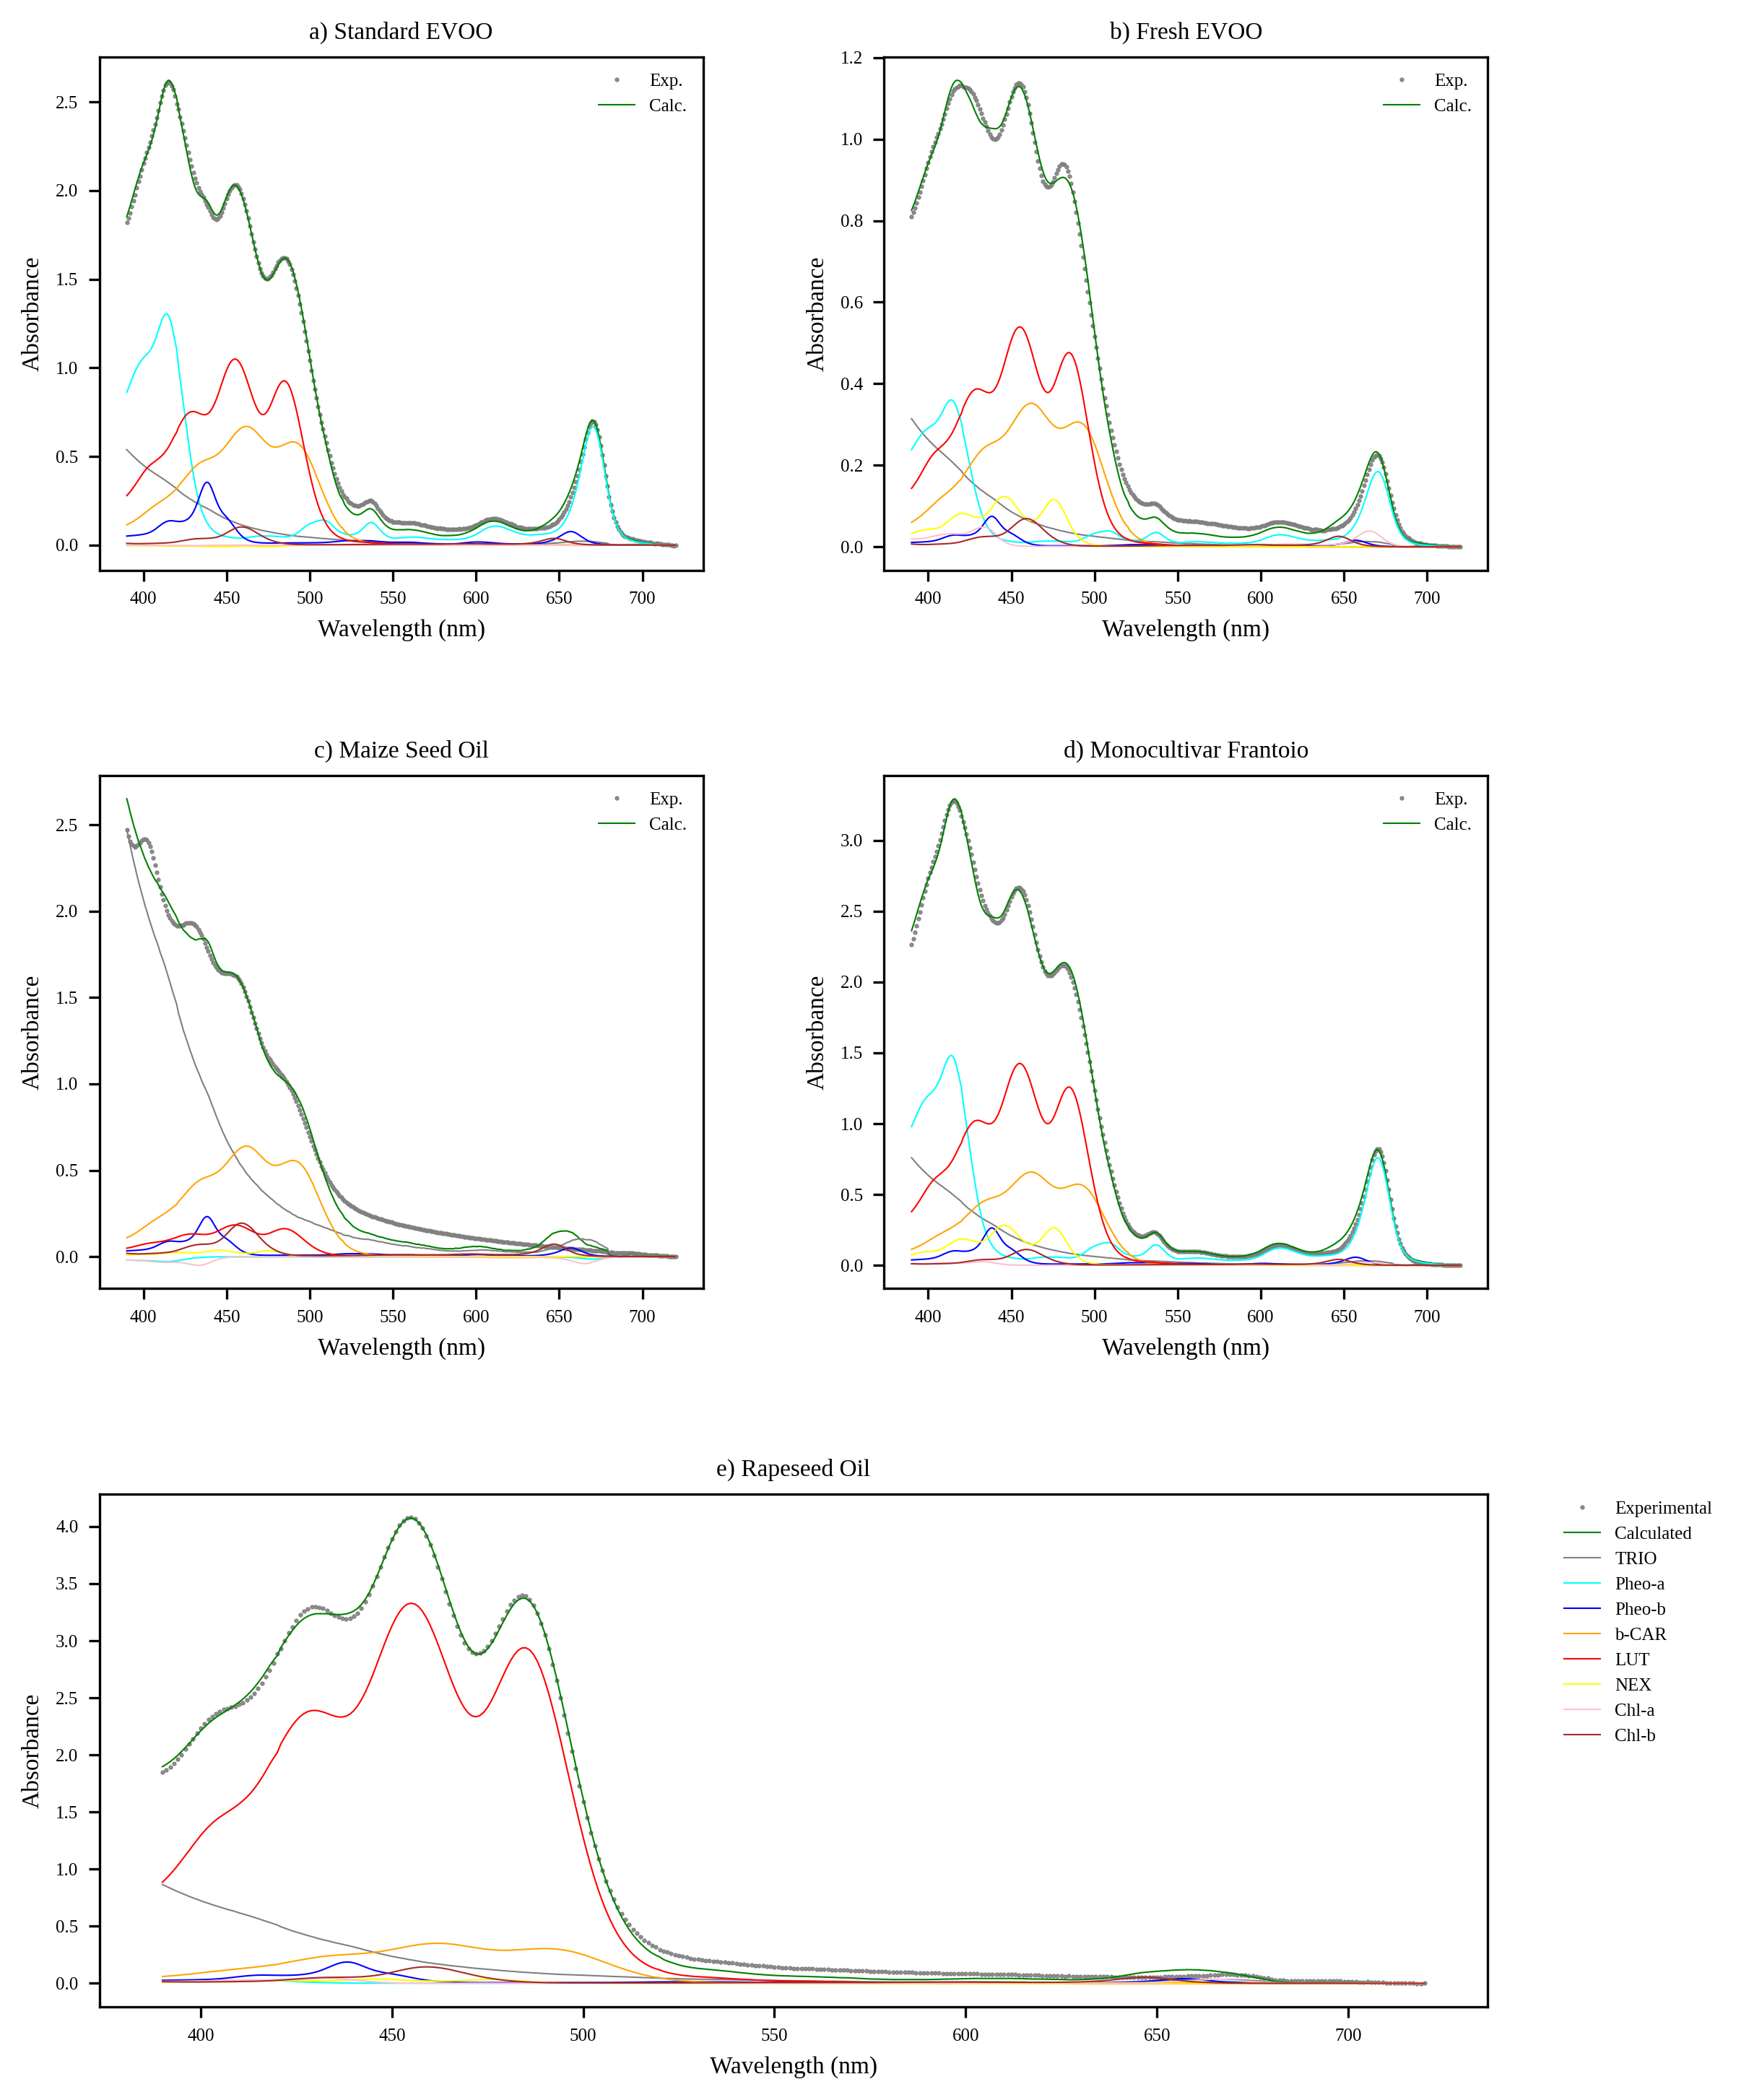

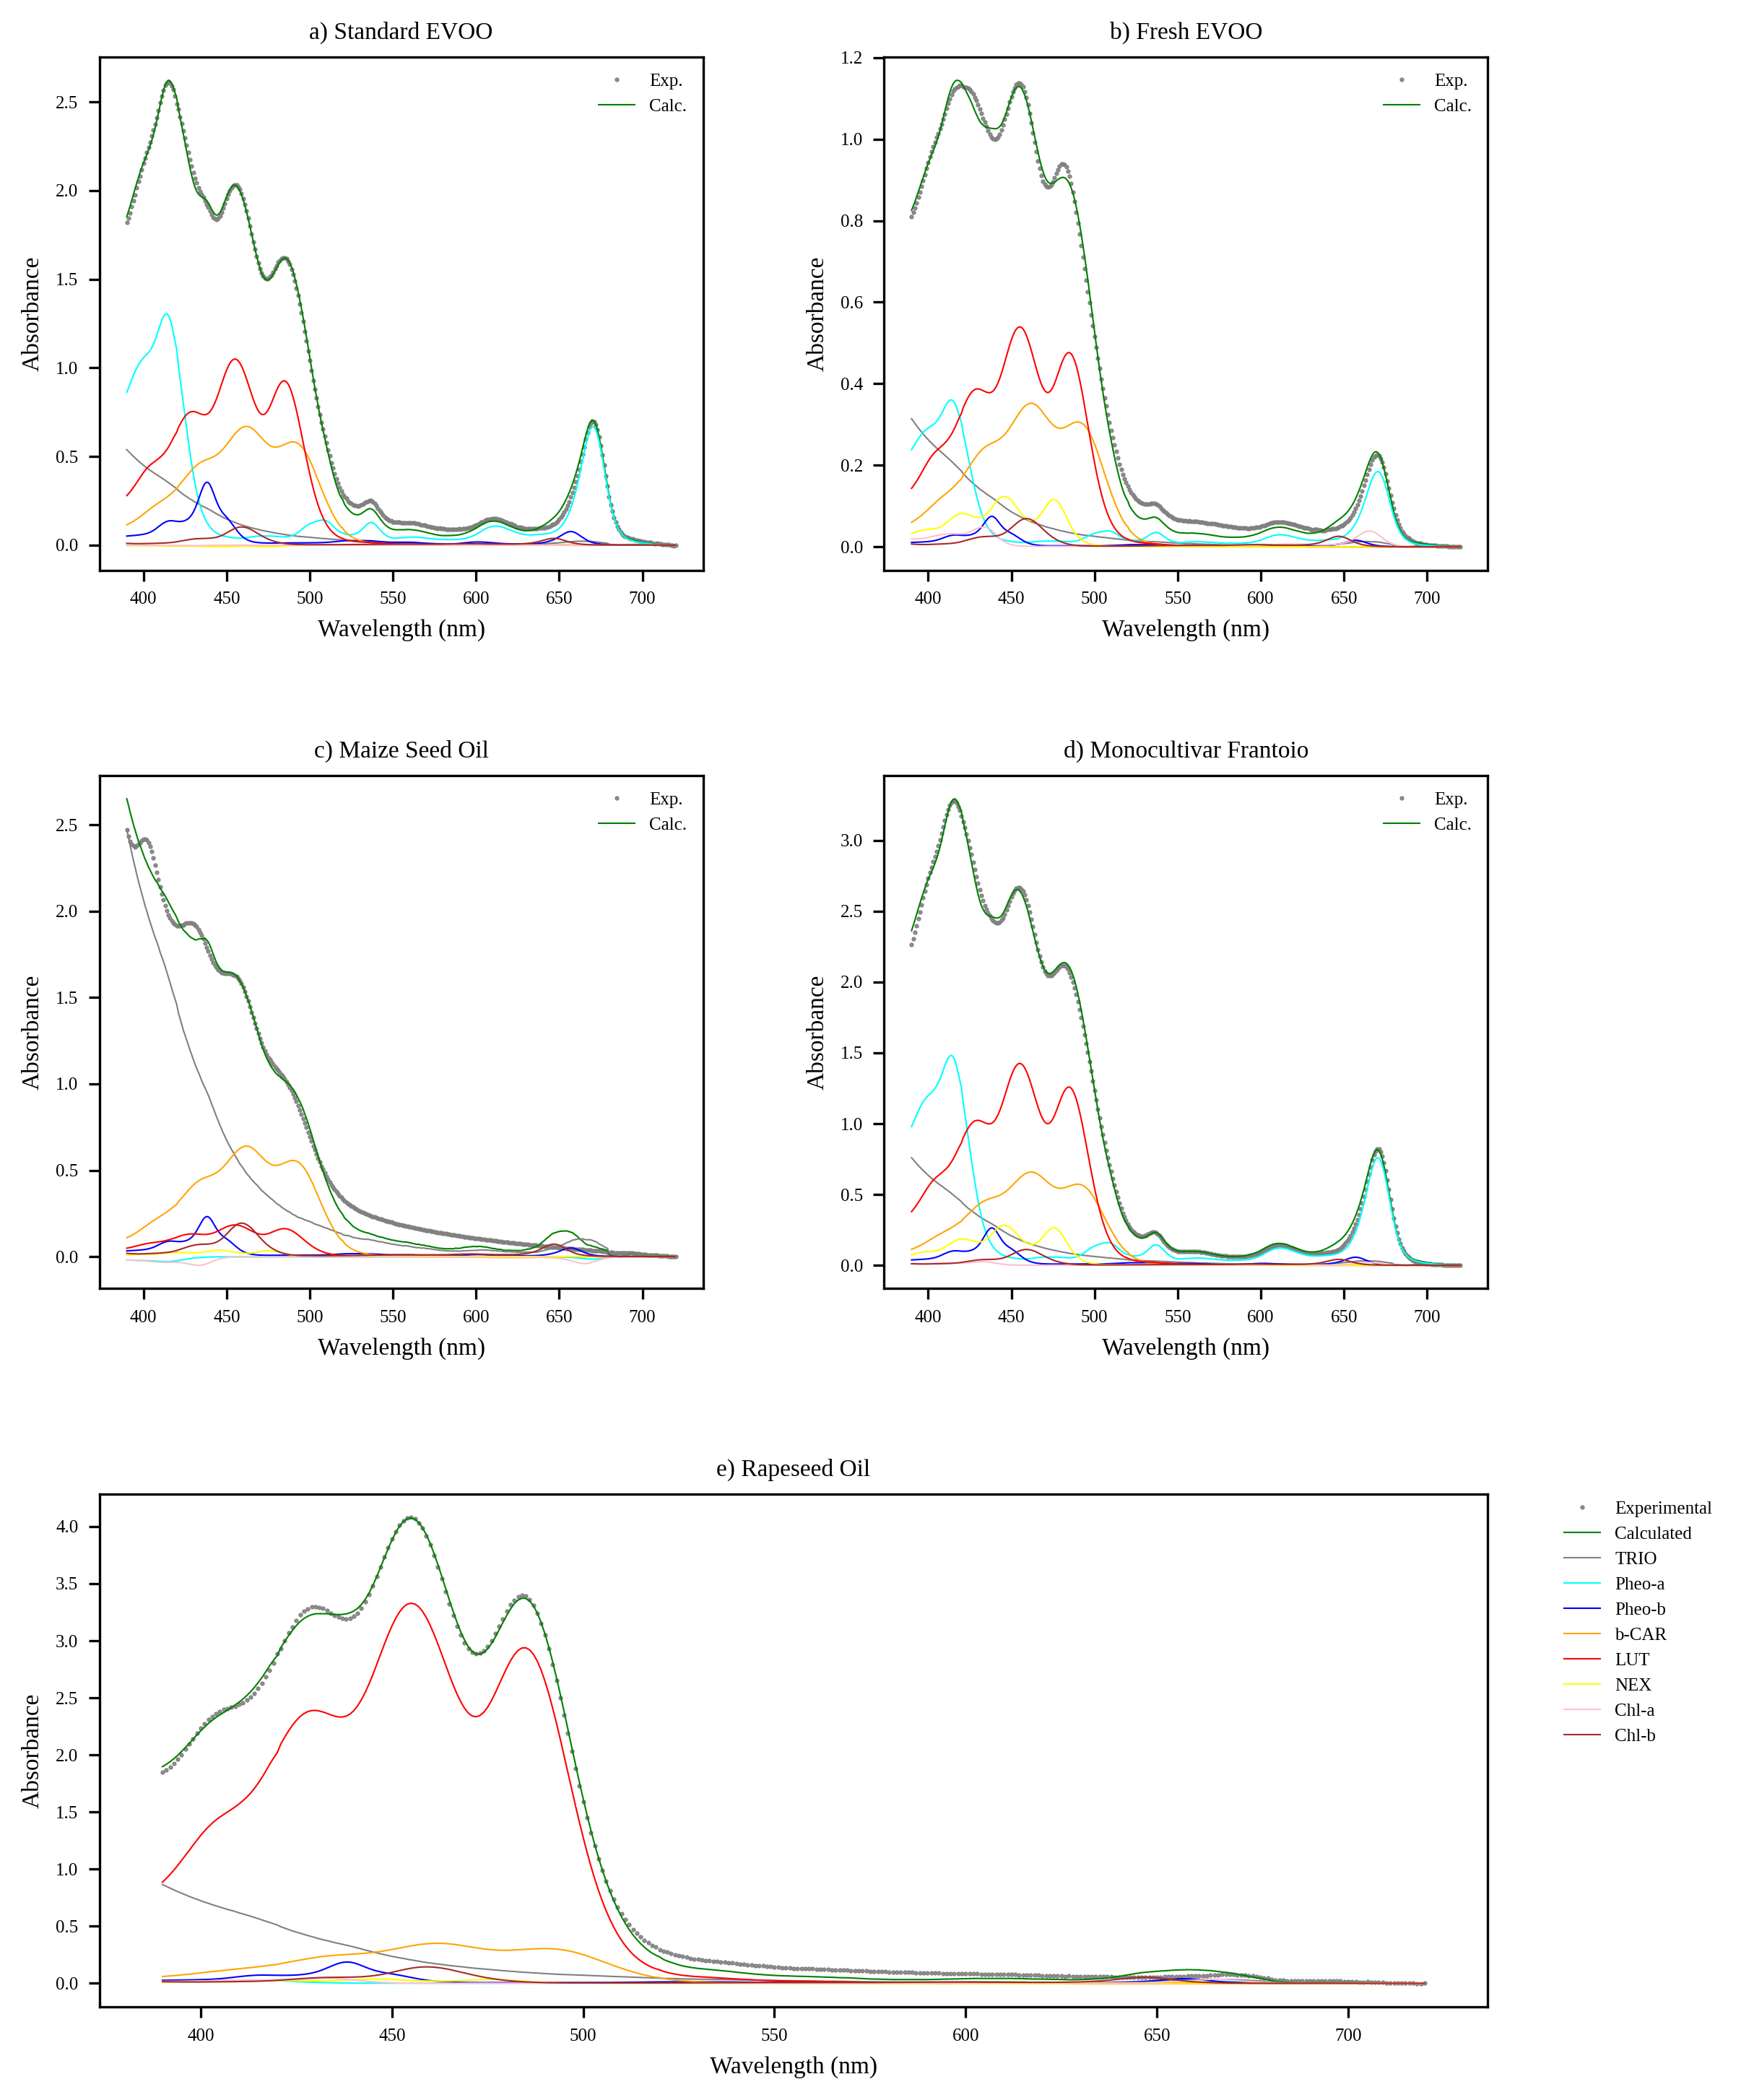

In [11]:
fig = create_ieee_figure(datasets, pigments_data)

In [14]:
# prompt: save fig as pdf

from matplotlib.backends.backend_pdf import PdfPages

def create_and_save_figure(filename='combined_spectral_analysis.pdf'):
    """Create and save figure using pre-processed results"""
    with PdfPages(filename) as pdf:
        fig = create_ieee_figure(datasets, pigments_data)
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)
    return fig

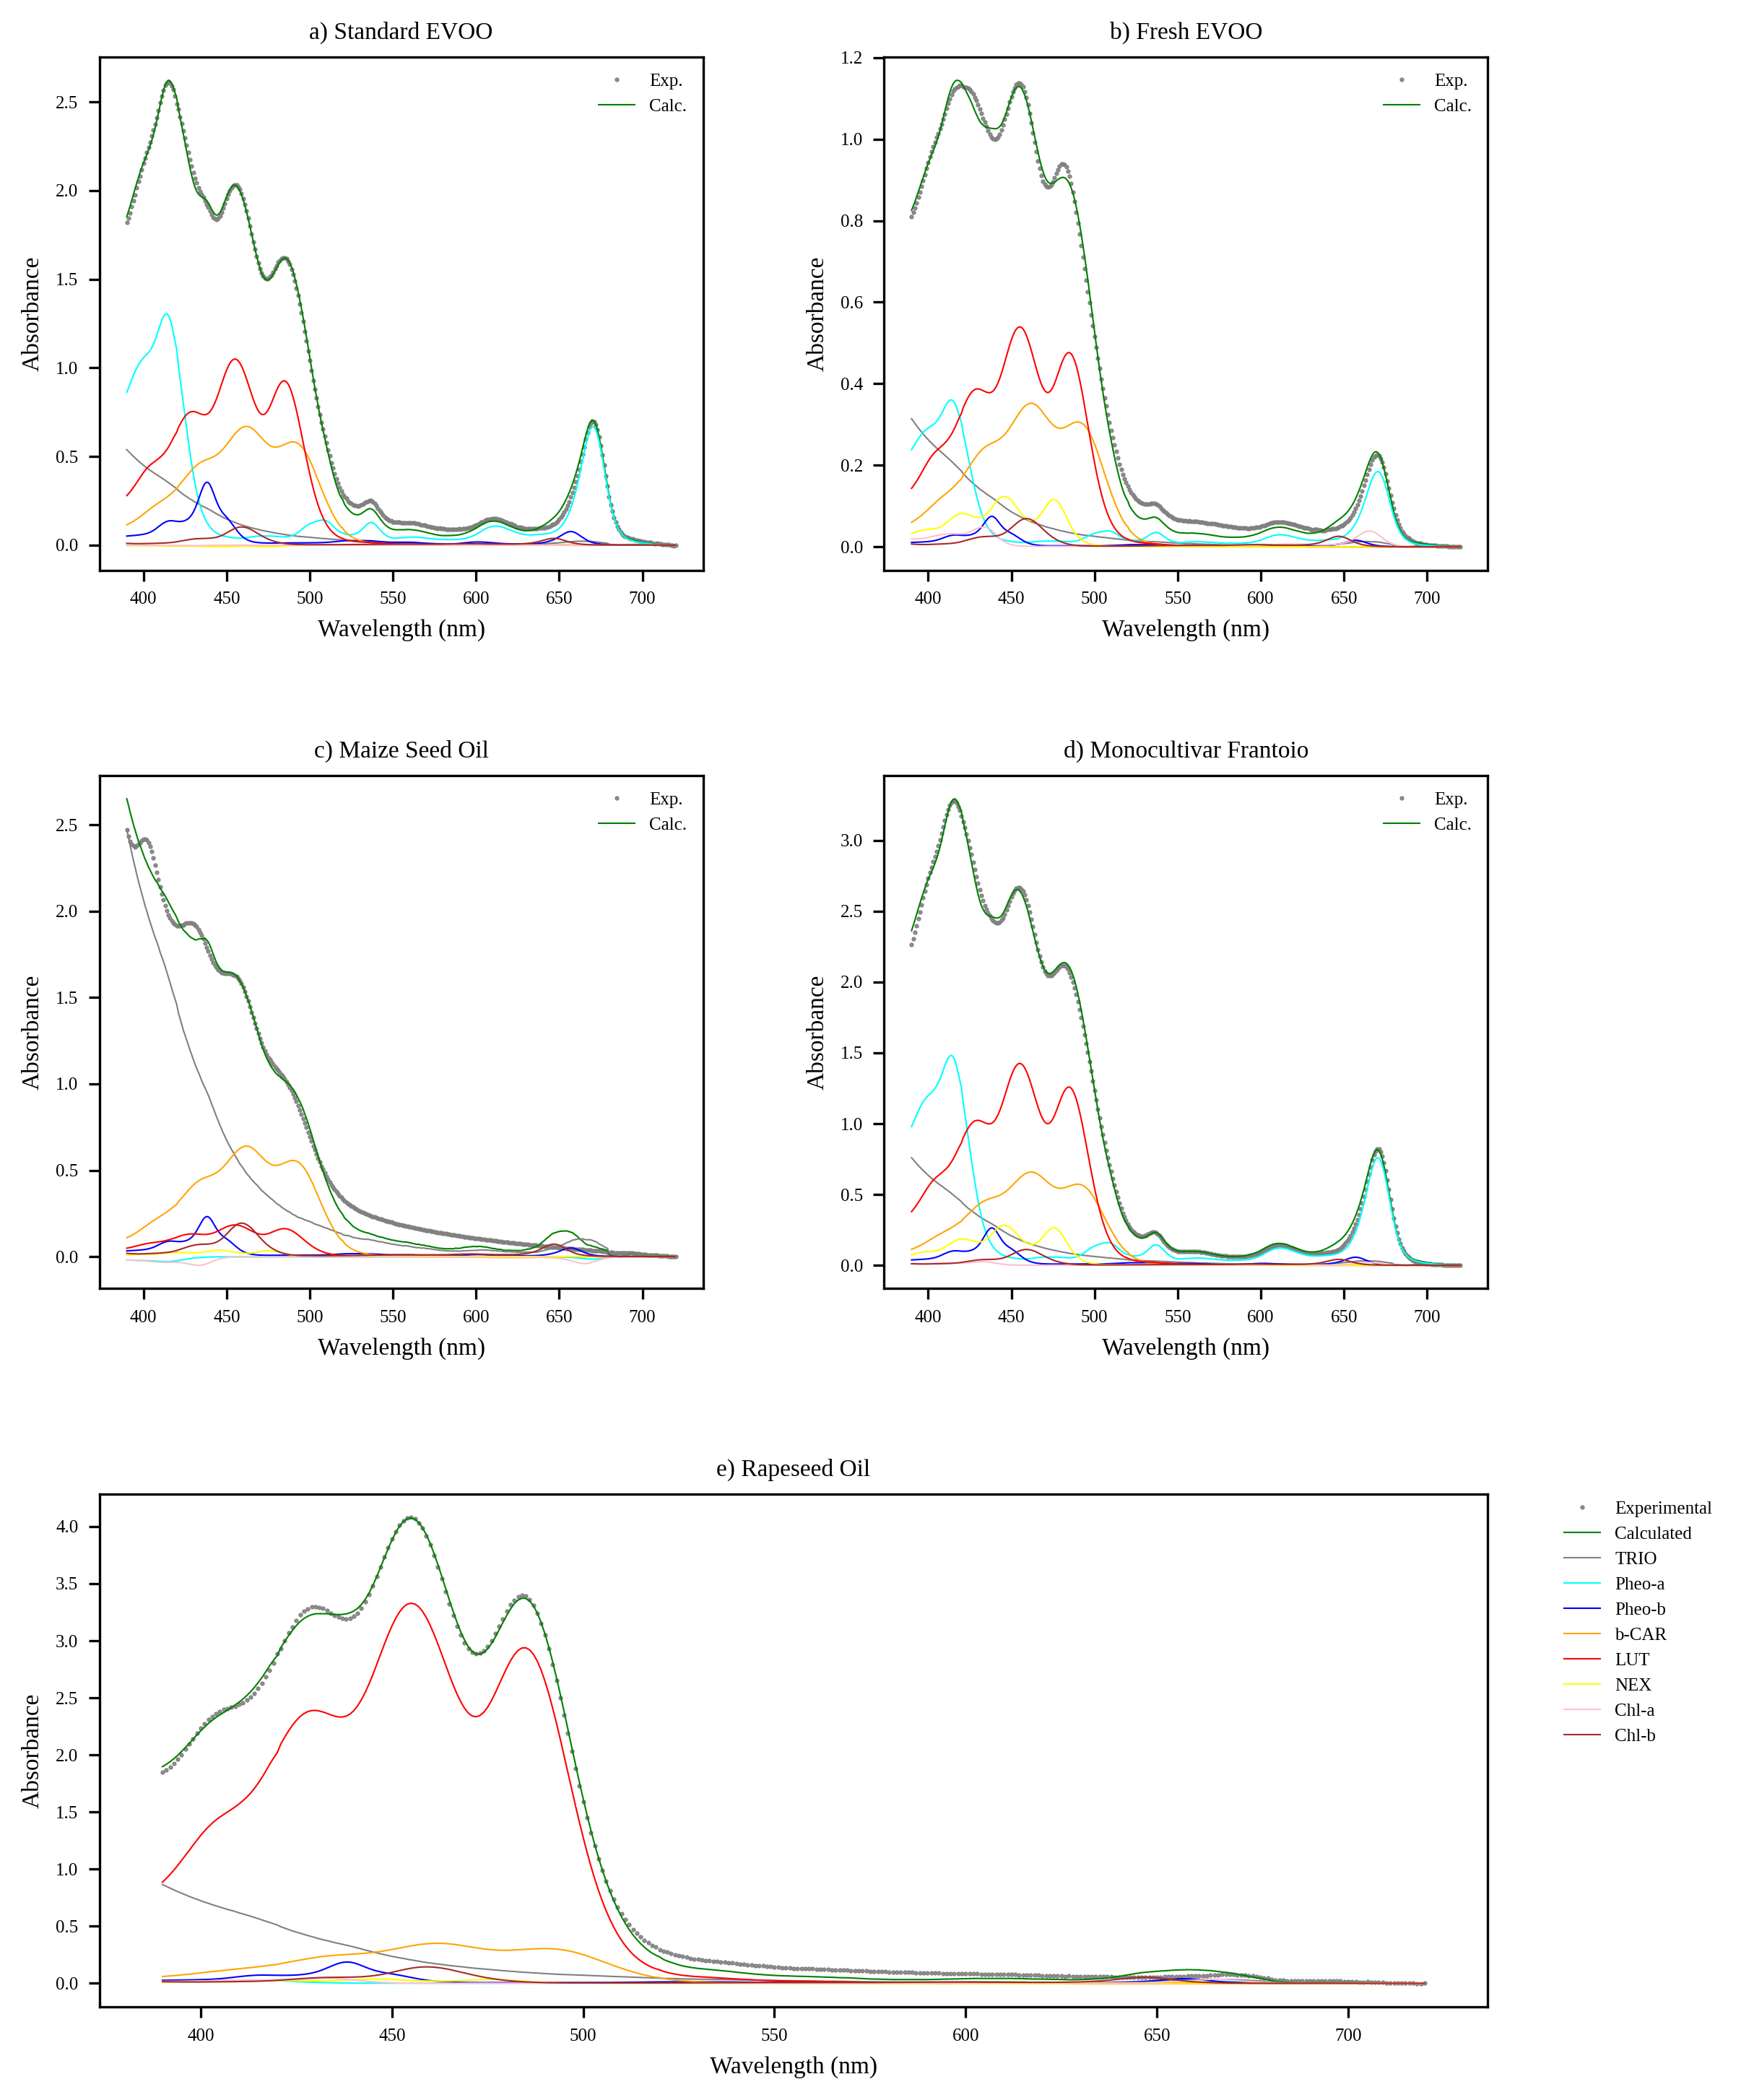

In [15]:
create_and_save_figure()